In [2]:
import pandas as pd
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
from datetime import timedelta
from polygon import RESTClient
import requests
from pandas.tseries.offsets import BDay

### 1. Collect data for the last 14 years - from 2010 to 2023 in daily granularity.
### 2. Identify top 10 outliers in each year.

In [3]:
def calculate_daily_returns(df, prev_close=None):
    if prev_close is not None:
        df.loc[df.index[0], 'prev_close'] = prev_close
    else:
        df['prev_close'] = df['c'].shift(1)
    df['daily_return'] = (df['c'] - df['prev_close']) / df['prev_close']
    df['abs_daily_return'] = df['daily_return'].abs()
    return df

def get_top_outliers(df, n=10):
    return df.nlargest(n, 'abs_daily_return')

# Define the API key and base URL
api_key = 'beBybSi8daPgsTp5yx5cHtHpYcrjp5Jq'

# Define the currency pairs and years
pair = "C:USDCHF"
years = range(2010, 2024)

# Initialize DataFrames
stats_data = pd.DataFrame(columns=['Year', 'Mean', 'Variance', 'Skewness', 'Kurtosis'])
full_data = pd.DataFrame()
outliers_data = pd.DataFrame()

# Loop over each year
for year in years:
	# Format the API endpoint
	start_date = f'{year}-01-01'
	end_date = f'{year}-12-31'
	url = f"https://api.polygon.io/v2/aggs/ticker/{pair}/range/1/day/{start_date}/{end_date}?adjusted=true&sort=asc&limit=50000&apiKey={api_key}"
	
	# Make the API request
	response = requests.get(url)
	data = response.json()
	
	# Check if the request was successful
	if response.status_code == 200 and 'results' in data:
		# Load data into a DataFrame
		df = pd.DataFrame(data['results'])
        # Converting timestamps
		df['date'] = pd.to_datetime(df['t'], unit='ms')
		df.drop(columns=['t'], inplace=True)
        # Calculating returns
		df = calculate_daily_returns(df)
        
		# Calculate basic statistical properties of the daily returns
		returns = df['daily_return'] 
		mean_return = returns.mean()
		variance_return = returns.var()
		skewness_return = skew(returns)
		kurtosis_return = kurtosis(returns)

		# Collect stats data by year
		year_stats = pd.DataFrame([[year, mean_return, variance_return, skewness_return, kurtosis_return]],
									columns=['Year', 'Mean', 'Variance', 'Skewness', 'Kurtosis'])
		stats_data = pd.concat([stats_data, year_stats], ignore_index=True)

		# Append the data to the full_data DataFrame for the current currency pair
		df['year'] = year
		full_data = pd.concat([full_data, df], ignore_index=True)

		# Find the top 10 outliers based on absolute values of the daily return value
		df['abs_daily_return'] = df['c'].abs()
		outliers = df.nlargest(10, 'abs_daily_return')

		# Append outliers to the outliers_data DataFrame for the current currency pair
		outliers['year'] = year
		outliers_data = pd.concat([outliers_data, outliers], ignore_index=True)

# Sort the data by date so that visualization could be done in a better way         
sorted_full_data = full_data.sort_values(by="date")
sorted_outliers_data = outliers_data.sort_values(by="date")

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_1441/3047513548.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  stats_data = pd.concat([stats_data, year_stats], ignore_index=True)


In [4]:
sorted_full_data

,v,vw,o,c,h,l,n,date,prev_close,daily_return,abs_daily_return,year
0,2359,1.0351,1.036260,1.036040,1.036880,1.033780,2359,2010-01-03,NaN,NaN,NaN,2010
1,69913,1.0329,1.036060,1.028910,1.041960,1.026210,69913,2010-01-04,1.03604,-0.006882,0.006882,2010
2,76822,1.0304,1.029000,1.033410,1.035960,1.025150,76822,2010-01-05,1.02891,0.004374,0.004374,2010
3,81057,1.0321,1.033410,1.027460,1.037830,1.024800,81057,2010-01-06,1.03341,-0.005758,0.005758,2010
4,72488,1.0321,1.027440,1.033700,1.037050,1.024140,72488,2010-01-07,1.02746,0.006073,0.006073,2010
...,...,...,...,...,...,...,...,...,...,...,...,...
4399,112192,0.8555,0.856000,0.853720,0.857960,0.852800,112192,2023-12-26,0.85581,-0.002442,0.002442,2023
4400,174820,0.8495,0.853590,0.842500,0.854870,0.840600,174820,2023-12-27,0.85372,-0.013142,0.013142,2023
4401,196178,0.8392,0.842400,0.843370,0.845145,0.833000,196178,2023-12-28,0.84250,0.001033,0.001033,2023
4402,214081,0.8403,0.843460,0.840710,0.843560,0.835400,214081,2023-12-29,0.84337,-0.003154,0.003154,2023


In [5]:
sorted_outliers_data

,v,vw,o,c,h,l,n,date,prev_close,daily_return,abs_daily_return,year
2,116306,1.1565,1.15104,1.16024,1.16191,1.14913,116306,2010-05-24,1.151030,0.008002,1.16024,2010
6,176660,1.1625,1.16023,1.15739,1.16950,1.15178,176660,2010-05-25,1.160240,-0.002456,1.15739,2010
4,135028,1.1579,1.15739,1.15873,1.16230,1.15139,135028,2010-05-26,1.157390,0.001158,1.15873,2010
3,103597,1.1541,1.15223,1.15927,1.15929,1.14801,103597,2010-05-28,1.152140,0.006188,1.15927,2010
5,4795,1.1580,1.15828,1.15740,1.15920,1.15709,4795,2010-05-30,1.159270,-0.001613,1.15740,2010
...,...,...,...,...,...,...,...,...,...,...,...,...
137,168297,0.9389,0.94201,0.93949,0.94290,0.93480,168297,2023-03-01,0.941868,-0.002524,0.93949,2023
132,164385,0.9419,0.93950,0.94180,0.94400,0.93890,164385,2023-03-02,0.939490,0.002459,0.94180,2023
138,2794,0.9366,0.93590,0.93680,0.93698,0.93550,2794,2023-03-05,0.935854,0.001011,0.93680,2023
130,172706,0.9356,0.93069,0.94223,0.94260,0.92830,172706,2023-03-07,0.930550,0.012552,0.94223,2023


In [6]:
def fetch_data(url):
    response = requests.get(url)
    if response.status_code != 200:
        print("Error fetching data:", response.status_code, response.text)
        return None
    data = response.json()
    if 'results' not in data:
        print("No 'results' key in response:", data)
        return None
    return data

def calculate_daily_returns_threshold(df, prev_close=None):
    if prev_close is not None:
        df.loc[df.index[0], 'prev_close'] = prev_close
    else:
        df['prev_close'] = df['c'].shift(1)
    df['daily_return'] = (df['c'] - df['prev_close']) / df['prev_close']
    # print(df['daily_return'])
    df['abs_daily_return'] = df['daily_return'].abs()
    return df

def convert_timestamps(df):
    df['date'] = pd.to_datetime(df['t'], unit='ms')
    df.drop(columns=['t'], inplace=True)
    return df


def fetch_daily_return_prior(symbol, current_date, previous_date, api_key):
    url = f'https://api.polygon.io/v2/aggs/ticker/{symbol}/range/1/day/{previous_date}/{current_date}?adjusted=true&sort=asc&apiKey={api_key}'
    data = fetch_data(url)
    if data and 'results' in data and len(data['results']) > 0:
        df = pd.DataFrame(data['results'])
        # print(df)
        df = convert_timestamps(df)
        # print(f"converted: {df}")
        df = df.loc[::-1].reset_index(drop=True)
        df = calculate_daily_returns_threshold(df)
        print(f"daily return: {df}")
        # print(f"daily_return {df['abs_daily_return']}")
        if len(df['abs_daily_return']) == 2:
            return df['abs_daily_return'].iloc[1]
    return None
    

def find_prior_outlier_threshold(df, symbol, api_key):
    df = df.sort_values(by='date').reset_index(drop=True)
    df['date'] = pd.to_datetime(df['date'])
    
    results = []
    
    for index, row in df.iterrows():
        current_date = row['date']
        current_return = row['abs_daily_return']
        print(f"outlier date: {current_date}")
        while True:
            # print(f"current_return: {current_return}")
            previous_date = current_date - pd.DateOffset(days=1)
            # print(f"previous date: {previous_date}")
            current_date_str = current_date.strftime('%Y-%m-%d')
            previous_date_str = previous_date.strftime('%Y-%m-%d')
            previous_return = fetch_daily_return_prior(symbol, current_date_str, previous_date_str, api_key)
            # print(f"previous return: {previous_return}")
            if previous_return is not None:
                if (current_return - previous_return) < 0:
                    
                    days_difference = (row['date'] - previous_date).days
                    # print(current_return - previous_return)
                    results.append({
                        'outlier_date': row['date'],
                        'prior_outlier_threshold_date': previous_date,
                        'days_difference': days_difference
                    })
                    # print()
                    break
                else:
                    current_date = previous_date
                    current_return = previous_return
            else:
                # print(f"Failed to fetch data for {previous_date_str}")
                # break
                current_date = previous_date

    return pd.DataFrame(results)


# Applying the corrected function to the data
prior_outlier_thresholds = find_prior_outlier_threshold(sorted_outliers_data, pair, api_key)


outlier date: 2010-05-24 00:00:00
daily return:         v      vw        o        c        h        l       n       date  \
0  116306  1.1565  1.15104  1.16024  1.16191  1.14913  116306 2010-05-24   
1    5423  1.1501  1.14963  1.15103  1.15160  1.14885    5423 2010-05-23   

   prev_close  daily_return  abs_daily_return  
0         NaN           NaN               NaN  
1     1.16024     -0.007938          0.007938  
daily return:       v      vw        o        c       h        l     n       date  \
0  5423  1.1501  1.14963  1.15103  1.1516  1.14885  5423 2010-05-23   

   prev_close  daily_return  abs_daily_return  
0         NaN           NaN               NaN  
daily return:         v      vw        o        c        h        l       n       date  \
0  148195  1.1499  1.14874  1.14911  1.15797  1.14496  148195 2010-05-21   

   prev_close  daily_return  abs_daily_return  
0         NaN           NaN               NaN  
daily return:         v      vw        o        c        h     

In [7]:
def fetch_daily_return_post(symbol, current_date, post_date, api_key):
    url = f'https://api.polygon.io/v2/aggs/ticker/{symbol}/range/1/day/{current_date}/{post_date}?adjusted=true&sort=asc&apiKey={api_key}'
    data = fetch_data(url)
    if data and 'results' in data and len(data['results']) > 0:
        df = pd.DataFrame(data['results'])
        # print(df)
        df = convert_timestamps(df)
        # print(f"converted: {df}")
        df = calculate_daily_returns_threshold(df)
        # print(f"daily return: {df}")
        # print(f"daily_return {df['abs_daily_return']}")
        if len(df['abs_daily_return']) == 2:
            return df['abs_daily_return'].iloc[1]
    return None


def find_post_outlier_threshold(df, symbol, api_key):
    df = df.sort_values(by='date').reset_index(drop=True)
    df['date'] = pd.to_datetime(df['date'])
    
    results = []
    
    for index, row in df.iterrows():
        current_date = row['date']
        current_return = row['abs_daily_return']
        # print(f"outlier date: {current_date}")
        while True:
            # print(f"current_return: {current_return}")
            post_date = current_date + pd.DateOffset(days=1)
            # print(f"previous date: {previous_date}")
            current_date_str = current_date.strftime('%Y-%m-%d')
            post_date_str = post_date.strftime('%Y-%m-%d')
            post_return = fetch_daily_return_post(symbol, current_date_str, post_date_str, api_key)
            # print(f"post return: {post_return}")
            if post_return is not None:
                if (current_return - post_return) < 0:
                    
                    days_difference = (post_date - row['date']).days
                    # print(current_return - post_return)
                    results.append({
                        'outlier_date': row['date'],
                        'post_outlier_threshold_date': post_date,
                        'days_difference': days_difference
                    })
                    # print()
                    break
                else:
                    current_date = post_date
                    current_return = post_return
            else:
                # print(f"Failed to fetch data for {post_date_str}")
                # break
                current_date = post_date

    return pd.DataFrame(results)

post_outlier_thresholds = find_post_outlier_threshold(sorted_outliers_data, pair, api_key)

No 'results' key in response: {'ticker': 'C:USDCHF', 'queryCount': 0, 'resultsCount': 0, 'adjusted': True, 'status': 'OK', 'request_id': 'c4013f9b19401d3781d508cedf59b10d'}


In [8]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_colwidth', None)
prior_outlier_thresholds.rename(columns={'outlier_date': 'date'}, inplace=True)
prior_outlier_thresholds

,date,prior_outlier_threshold_date,days_difference
0,2010-05-24,2010-05-19,5
1,2010-05-25,2010-05-23,2
2,2010-05-26,2010-05-24,2
3,2010-05-28,2010-05-24,4
4,2010-05-30,2010-05-24,6
...,...,...,...
135,2023-03-01,2023-02-27,2
136,2023-03-02,2023-02-28,2
137,2023-03-05,2023-03-02,3
138,2023-03-07,2023-03-02,5


In [9]:
post_outlier_thresholds

,outlier_date,post_outlier_threshold_date,days_difference
0,2010-05-24,2010-05-27,3
1,2010-05-25,2010-05-27,2
2,2010-05-26,2010-05-28,2
3,2010-05-28,2010-06-03,6
4,2010-05-30,2010-06-03,4
...,...,...,...
135,2023-03-01,2023-03-03,2
136,2023-03-02,2023-03-05,3
137,2023-03-05,2023-03-07,2
138,2023-03-07,2023-03-09,2


In [10]:
prior_outlier_thresholds.rename(columns={'outlier_date': 'date'}, inplace=True)
sorted_outliers_data = pd.merge(
    sorted_outliers_data,
    prior_outlier_thresholds[['date', 'days_difference']],
    on = 'date',
    how='left'
)
sorted_outliers_data.rename(columns={'days_difference':'pre_threshold'}, inplace=True)

post_outlier_thresholds.rename(columns={'outlier_date': 'date'}, inplace=True)
sorted_outliers_data = pd.merge(
    sorted_outliers_data,
    post_outlier_thresholds[['date', 'days_difference']],
    on = 'date',
)
sorted_outliers_data.rename(columns={'days_difference':'post_threshold'}, inplace=True)

In [13]:
sorted_outliers_data

,v,vw,o,c,h,l,n,date,prev_close,daily_return,abs_daily_return,year,pre_threshold,post_threshold
0,116306,1.1565,1.15104,1.16024,1.16191,1.14913,116306,2010-05-24,1.151030,0.008002,1.16024,2010,5,3
1,176660,1.1625,1.16023,1.15739,1.16950,1.15178,176660,2010-05-25,1.160240,-0.002456,1.15739,2010,2,2
2,135028,1.1579,1.15739,1.15873,1.16230,1.15139,135028,2010-05-26,1.157390,0.001158,1.15873,2010,2,2
3,103597,1.1541,1.15223,1.15927,1.15929,1.14801,103597,2010-05-28,1.152140,0.006188,1.15927,2010,4,6
4,4795,1.1580,1.15828,1.15740,1.15920,1.15709,4795,2010-05-30,1.159270,-0.001613,1.15740,2010,6,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,168297,0.9389,0.94201,0.93949,0.94290,0.93480,168297,2023-03-01,0.941868,-0.002524,0.93949,2023,2,2
136,164385,0.9419,0.93950,0.94180,0.94400,0.93890,164385,2023-03-02,0.939490,0.002459,0.94180,2023,2,3
137,2794,0.9366,0.93590,0.93680,0.93698,0.93550,2794,2023-03-05,0.935854,0.001011,0.93680,2023,3,2
138,172706,0.9356,0.93069,0.94223,0.94260,0.92830,172706,2023-03-07,0.930550,0.012552,0.94223,2023,5,2


In [19]:
print(sorted_outliers_data.loc[sorted_outliers_data['date'] == '2010-05-24', 'pre_threshold'].values[0])

5


In [5]:
stats_data

,Year,Mean,Variance,Skewness,Kurtosis
0,2010,-0.000314,0.000038,NaN,NaN
1,2011,0.000070,0.000097,NaN,NaN
2,2012,-0.000074,0.000024,NaN,NaN
3,2013,-0.000060,0.000028,NaN,NaN
4,2014,0.000349,0.000015,NaN,NaN
5,2015,0.000075,0.000128,NaN,NaN
6,2016,0.000067,0.000020,NaN,NaN
7,2017,-0.000133,0.000015,NaN,NaN
8,2018,0.000036,0.000013,NaN,NaN
9,2019,-0.000068,0.000010,NaN,NaN


Skewness and Kurtosis (NaN): The NaN values likely indicate that daily returns for many years are very close to zero with little variance, thus not allowing for a meaningful calculation of skewness and kurtosis. This could mean the market is highly stable on a day-to-day basis, with changes being very subtle.

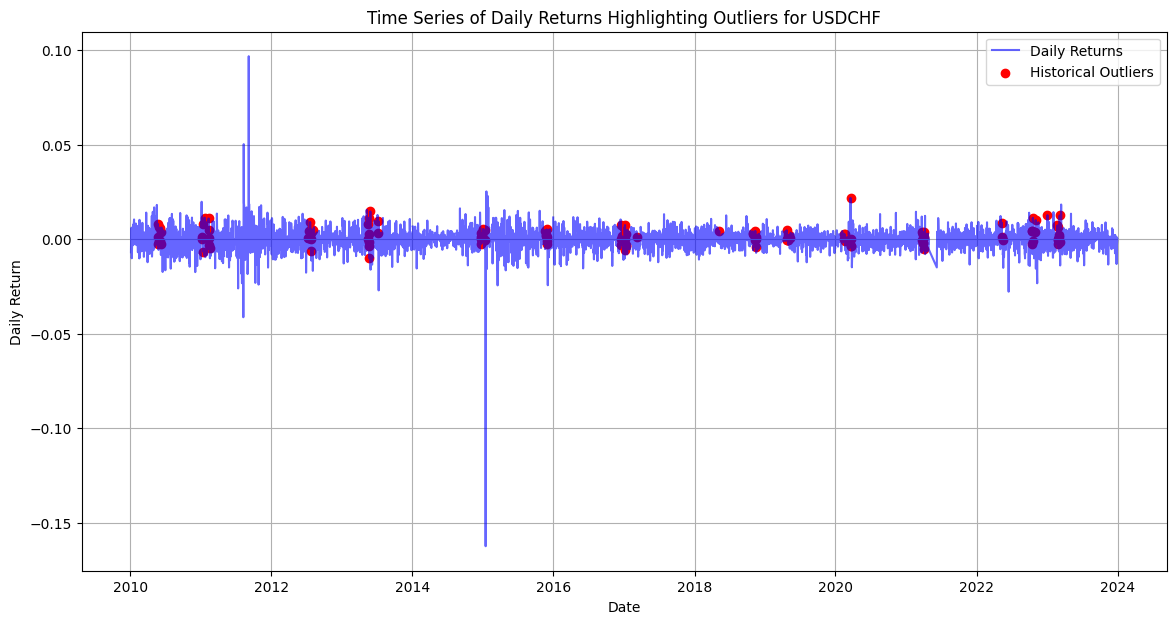

In [6]:
def plot_data_with_outliers(full_data, outliers_data):
    plt.figure(figsize=(14, 7))
    plt.plot(full_data['date'], full_data['daily_return'], label='Daily Returns', color='blue', alpha=0.6)
    plt.scatter(outliers_data['date'], outliers_data['daily_return'], color='red', label='Historical Outliers')
    plt.xlabel('Date')
    plt.ylabel('Daily Return')
    plt.title('Time Series of Daily Returns Highlighting Outliers for USDCHF')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot data with outliers
plot_data_with_outliers(sorted_full_data, outliers_data)

### 3. Collect data of 3 days prior and post for each of these outliers in hourly granularity.

In [15]:
# Convert dates in dataset to datetime objects
sorted_outliers_data['date'] = pd.to_datetime(sorted_outliers_data['date'])
mean_daily_return = sorted_outliers_data['daily_return'].mean()
# date_ranges = pd.DataFrame({
#     "start_date": sorted_outliers_data['date'] - BDay(3),
#     "end_date": sorted_outliers_data['date'] + BDay(3),
#     "outlier_date": sorted_outliers_data['date'],
#     "year": sorted_outliers_data['year']
# })

date_ranges = pd.DataFrame({
    "start_date": sorted_outliers_data.apply(lambda row: row['date'] - BDay(row['pre_threshold']), axis=1),
    "end_date": sorted_outliers_data.apply(lambda row: row['date'] + BDay(row['post_threshold']), axis=1),
    "outlier_date": sorted_outliers_data['date'],
    "year": sorted_outliers_data['year']
})

date_ranges

,start_date,end_date,outlier_date,year
0,2010-05-17,2010-05-27,2010-05-24,2010
1,2010-05-21,2010-05-27,2010-05-25,2010
2,2010-05-24,2010-05-28,2010-05-26,2010
3,2010-05-24,2010-06-07,2010-05-28,2010
4,2010-05-21,2010-06-03,2010-05-30,2010
...,...,...,...,...
135,2023-02-27,2023-03-03,2023-03-01,2023
136,2023-02-28,2023-03-07,2023-03-02,2023
137,2023-03-01,2023-03-07,2023-03-05,2023
138,2023-02-28,2023-03-09,2023-03-07,2023


### Calculate Daily returns and Recovery classification

In [24]:

def classify_recovery_range(daily_data, outlier_date, mean_daily_return):
    # Filter the data for the specified range
    # range_data = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
    # if range_data.empty:
    #     return "no data"
    # # Calculate cumulative percentage change
    # cumulative_change = range_data['pct_change'].sum()
    # # Classify the recovery based on the cumulative change
    # if cumulative_change >= fast_threshold:
    #     return 'fast recovery'
    # else:
    #     return 'slow recovery'
    pre_threshold = sorted_outliers_data.loc[sorted_outliers_data['date'] == outlier_date, 'pre_threshold'].values[0]
    post_threshold = sorted_outliers_data.loc[sorted_outliers_data['date'] == outlier_date, 'post_threshold'].values[0]
    
    pre_period_cumulative_return = daily_data[daily_data['date'] < outlier_date]['daily_return'].sum()
    post_period_cumulative_return = daily_data[daily_data['date'] >= outlier_date]['daily_return'].sum()

    pre_threshold_return = mean_daily_return * pre_threshold
    post_threshold_return = mean_daily_return * post_threshold

    if pre_period_cumulative_return > pre_threshold_return:
            pre_recovery_classification = 'fast recovery'
    else:
        pre_recovery_classification = 'slow recovery'

    if post_period_cumulative_return > post_threshold_return:
        post_recovery_classification = 'fast recovery'
    else:
        post_recovery_classification = 'slow recovery'

    return pre_recovery_classification, post_recovery_classification

def calculate_daily_returns(df, prev_close=None):
    if prev_close is not None:
        df.loc[df.index[0], 'prev_close'] = prev_close
    else:
        df['prev_close'] = df['c'].shift(1)
    df['daily_return'] = (df['c'] - df['prev_close']) / df['prev_close']
    df['abs_daily_return'] = df['daily_return'].abs()
    df['pct_change'] = df['c'].pct_change() * 100
    
    df['direction'] = df['pct_change'].apply(lambda x: 'Up' if x > 0 else 'Down')
    df['pct_change'] = df['pct_change'].abs()
    
    return df




### Fetch Daily Data

In [22]:
def fetch_daily_data(symbol, start_date, end_date, api_key, outlier_date):
    formatted_start_date = start_date.strftime('%Y-%m-%d')
    formatted_end_date = end_date.strftime('%Y-%m-%d')

    prev_day_date = start_date - timedelta(days=1)
    formatted_prev_day_date = prev_day_date.strftime('%Y-%m-%d')
    url_prev_day = f"https://api.polygon.io/v2/aggs/ticker/{symbol}/range/1/day/{formatted_prev_day_date}/{formatted_prev_day_date}?apiKey={api_key}"

    response_prev_day = requests.get(url_prev_day)
    if response_prev_day.status_code == 200:
        response_prev_data = response_prev_day.json()
        if 'results' in response_prev_data and len(response_prev_data['results']) > 0:
            df_prev_day = pd.DataFrame(response_prev_data['results'])
            df_prev_day['date'] = pd.to_datetime(df_prev_day['t'], unit='ms')
            df_prev_day.drop(columns=['t'], inplace=True)
            # prev_close = response_prev_data['results'][0]['c']
        else:
            print(f"No previous day data available for {formatted_prev_day_date}")
            df_prev_day = pd.DataFrame()
    else:
        print(f"Failed to fetch previous day data: {response_prev_day.status_code} - {response_prev_day.text}")
        df_prev_day = pd.DataFrame()
    
    url = f"https://api.polygon.io/v2/aggs/ticker/{symbol}/range/1/day/{formatted_start_date}/{formatted_end_date}?apiKey={api_key}"
    response = requests.get(url)
    
    if response.status_code != 200:
        print(f"Failed to fetch data: {response.status_code} - {response.text}")
        return None
    
    response_data = response.json()
    
    if 'results' not in response_data:
        print(f"No 'results' in response: {response_data}")
        return None

    df_range = pd.DataFrame(response_data['results'])
    df_range['date'] = pd.to_datetime(df_range['t'], unit='ms')
    df_range.drop(columns=['t'], inplace=True)

    df = pd.concat([df_prev_day, df_range], ignore_index=True)
    # print(df)
    # print(all_data_daily)
    daily_data = calculate_daily_returns(df)

    
    pre_recovery, post_recovery = classify_recovery_range(daily_data, outlier_date, mean_daily_return)
    daily_data.loc[daily_data['date'] < outlier_date, 'recovery'] = pre_recovery
    daily_data.loc[daily_data['date'] >= outlier_date, 'recovery'] = post_recovery
    
    daily_data.set_index('date', inplace=True)

    full_index = pd.date_range(start=start_date, end=end_date + timedelta(days=1), freq='D')
    daily_data = daily_data.reindex(full_index)
    
    daily_data.reset_index(inplace=True)
    daily_data.rename(columns={'index': 'date'}, inplace=True)
    
    return daily_data



In [25]:
# Initialize empty DataFrame
all_data_daily = pd.DataFrame()

# Initialize an outlier identifier starting from 1 or any specific number
outlier_id = 1

for index, row in date_ranges.iterrows():
    # Convert start_date, end_date, and outlier_date to Timestamp for consistent comparison
    start_date_ts = pd.Timestamp(row['start_date'])
    end_date_ts = pd.Timestamp(row['end_date']) + pd.Timedelta(days=1)  # Extend the end date by one additional day
    outlier_date_ts = pd.Timestamp(row['outlier_date'])
    
    # Get hourly data for the range including 3 days before and after the outlier
    daily_data = fetch_daily_data(pair, start_date_ts, end_date_ts, api_key, outlier_date_ts)
    # print(daily_data)
    # Check if hourly_data is not None before processing
    if daily_data is not None:
        # Assign the current outlier_id to the data
        daily_data['outlier_id'] = outlier_id

        # Filter out weekdends
        daily_data = daily_data[~daily_data['date'].dt.weekday.isin([5,6])]
        
        # prior_data from start_date to outlier_date inclusive
        prior_data = daily_data[(daily_data['date'] >= start_date_ts) & (daily_data['date'] < outlier_date_ts)]
        prior_data["day type"] = "prior day"

        # outlier_data is for the hourly data on the day of the outlier
        outlier_data = daily_data[(daily_data['date'].dt.date == outlier_date_ts.date())]
        outlier_data["day type"] = "outlier day"
        
        # post_data from the day after outlier_date to end_date
        post_outlier_ts = outlier_date_ts + pd.Timedelta(days=1)  # Starting the day after the outlier_date
        post_data = daily_data[(daily_data['date'] >= post_outlier_ts) & (daily_data['date'] <= end_date_ts)]
        post_data["day type"] = "post day"
        
        # Concatenate the data from this iteration to the cumulative DataFrame
        all_data_daily = pd.concat([all_data_daily, prior_data, outlier_data, post_data])

        # Increment the outlier_id for the next iteration
        outlier_id += 1

    else:
        print(f"Data not available for symbol {pair} from {row['start_date'].date()} to {row['end_date'].date()}")

# Add the day column to the final DataFrame
all_data_daily['day'] = all_data_daily['date'].dt.day_name()
# Optionally, you can reset the index of the final DataFrame if it becomes non-unique after concatenations
all_data_daily.reset_index(drop=True, inplace=True)

/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_1441/201843607.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_1441/201843607.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_1441/201843607.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

No previous day data available for 2014-12-25
No previous day data available for 2014-12-25


/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_1441/201843607.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_data["day type"] = "prior day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_1441/201843607.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outlier_data["day type"] = "outlier day"
/var/folders/7z/f62wpz017pg_dm6f4f1hymgh0000gn/T/ipykernel_1441/201843607.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

In [26]:
# Reset the index to have simple numbers and separate "date" and "time" columns
all_data_daily.reset_index(inplace=True)
all_data_daily.rename(columns={'index': 'New'}, inplace=True)

# Convert date to string format if necessary
all_data_daily['date'] = all_data_daily['date'].astype(str)

# Extract date and time from the date string
all_data_daily['Date'] = all_data_daily['date'].str[:10]
all_data_daily['Time'] = all_data_daily['date'].str[11:19]

# Drop the 'date' column if it's no longer needed
all_data_daily.drop(columns=['date', 'New', 'v', 'Time'], inplace=True)

In [27]:
all_data_daily

,vw,o,c,h,l,n,prev_close,daily_return,abs_daily_return,pct_change,direction,recovery,outlier_id,day type,day,Date
0,1.1360,1.13310,1.13252,1.14450,1.12966,219929.0,1.13310,-0.000512,0.000512,0.051187,Down,fast recovery,1,prior day,Monday,2010-05-17
1,1.1358,1.13250,1.15303,1.15312,1.12665,239012.0,1.13252,0.018110,0.018110,1.811006,Up,fast recovery,1,prior day,Tuesday,2010-05-18
2,1.1503,1.15299,1.15232,1.15850,1.14174,225568.0,1.15303,-0.000616,0.000616,0.061577,Down,fast recovery,1,prior day,Wednesday,2010-05-19
3,1.1508,1.15235,1.14872,1.15736,1.14512,191518.0,1.15232,-0.003124,0.003124,0.312413,Down,fast recovery,1,prior day,Thursday,2010-05-20
4,1.1499,1.14874,1.14911,1.15797,1.14496,148195.0,1.14872,0.000340,0.000340,0.033951,Up,fast recovery,1,prior day,Friday,2010-05-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1212,0.9337,0.93681,0.93055,0.93726,0.92985,150659.0,0.93680,-0.006672,0.006672,0.667165,Down,fast recovery,140,prior day,Monday,2023-03-06
1213,0.9356,0.93069,0.94223,0.94260,0.92830,172706.0,0.93055,0.012552,0.012552,1.255172,Up,fast recovery,140,prior day,Tuesday,2023-03-07
1214,0.9418,0.94223,0.94085,0.94384,0.93879,154890.0,0.94223,-0.001465,0.001465,0.146461,Down,slow recovery,140,outlier day,Wednesday,2023-03-08
1215,0.9374,0.94087,0.93288,0.94157,0.93194,156286.0,0.94085,-0.008471,0.008471,0.847106,Down,slow recovery,140,post day,Thursday,2023-03-09


In [28]:
all_data_daily.to_csv("/Users/nachiketkhare/Desktop/USDCHF_daily.csv")

In [158]:
# # Initialize empty DataFrame
# all_data1 = pd.DataFrame()

# # Initialize an outlier identifier starting from 1 or any specific number
# outlier_id = 1


# for index, row in date_ranges.iterrows():
#     # Convert start_date, end_date, and outlier_date to Timestamp for consistent comparison
#     start_date_ts = pd.Timestamp(row['start_date'])
#     end_date_ts = pd.Timestamp(row['end_date']) + pd.Timedelta(days=1)  # Extend the end date by one additional day
#     outlier_date_ts = pd.Timestamp(row['outlier_date'])
    
#     # Get hourly data for the range including 3 days before and after the outlier
#     hourly_data = fetch_and_process_hourly_data(pair, start_date_ts, end_date_ts, api_key)
#     print(hourly_data)
#     # Check if hourly_data is not None before processing
#     if hourly_data is not None:
#         # Assign the current outlier_id to the data
#         hourly_data['outlier_id'] = outlier_id

#         # Filter out weekdends
#         hourly_data = hourly_data[~hourly_data['date'].dt.weekday.isin([5,6])]
        
#         # prior_data from start_date to outlier_date inclusive
#         prior_data = hourly_data[(hourly_data['date'] >= start_date_ts) & (hourly_data['date'] < outlier_date_ts)]
#         prior_data["day type"] = "prior day"

#         # outlier_data is for the hourly data on the day of the outlier
#         outlier_data = hourly_data[(hourly_data['date'].dt.date == outlier_date_ts.date())]
#         outlier_data["day type"] = "outlier day"

        
#         # post_data from the day after outlier_date to end_date
#         post_outlier_ts = outlier_date_ts + pd.Timedelta(days=1)  # Starting the day after the outlier_date
#         post_data = hourly_data[(hourly_data['date'] >= post_outlier_ts) & (hourly_data['date'] <= end_date_ts)]
#         post_data["day type"] = "post day"
        
#         # Concatenate the data from this iteration to the cumulative DataFrame
#         all_data1 = pd.concat([all_data1, prior_data, outlier_data, post_data])

#         # Increment the outlier_id for the next iteration
#         outlier_id += 1

#     else:
#         print(f"Data not available for symbol {pair} from {row['start_date'].date()} to {row['end_date'].date()}")

# # Add the day column to the final DataFrame
# all_data1['day'] = all_data1['date'].dt.day_name()
# # Optionally, you can reset the index of the final DataFrame if it becomes non-unique after concatenations
# all_data1.reset_index(drop=True, inplace=True)

In [157]:
# all_data1

In [15]:
# # Reset the index to have simple numbers and separate "date" and "time" columns
# all_data1.reset_index(inplace=True)
# all_data1.rename(columns={'index': 'New'}, inplace=True)

# # Convert date to string format if necessary
# all_data1['date'] = all_data1['date'].astype(str)

# # Extract date and time from the date string
# all_data1['Date'] = all_data1['date'].str[:10]
# all_data1['Time'] = all_data1['date'].str[11:19]

# # Drop the 'date' column if it's no longer needed
# all_data1.drop(columns=['date', 'New', 'v'], inplace=True)

In [13]:
# all_data1.to_csv("/Users/nachiketkhare/Desktop/USDCHF_hourly_new_latest1.csv")

In [140]:
# def fetch_hourly_data_chunk(symbol, start_date, end_date, api_key):
#     formatted_start_date = start_date.strftime('%Y-%m-%d')
#     formatted_end_date = end_date.strftime('%Y-%m-%d')

#     url = f"https://api.polygon.io/v2/aggs/ticker/{symbol}/range/1/hour/{formatted_start_date}/{formatted_end_date}?apiKey={api_key}"
#     response = requests.get(url)
    
#     if response.status_code != 200:
#         print(f"Failed to fetch data: {response.status_code} - {response.text}")
#         return None
    
#     response_data = response.json()
    
#     if 'results' not in response_data:
#         print(f"No 'results' in response: {response_data}")
#         return None

#     df = pd.DataFrame(response_data['results'])
#     df['date'] = pd.to_datetime(df['t'], unit='ms')
#     df.drop(columns=['t'], inplace=True)
    
#     return df

# def fetch_and_process_hourly_data(symbol, start_date, end_date, api_key):
#     # pd.set_option('display.max_rows', None)
#     # pd.set_option('display.max_columns', None)
#     # pd.set_option('display.max_colwidth', None)
    
#     # Split the date range into smaller chunks
#     chunk_size = 3  # Fetch data in 7-day chunks
#     date_ranges = [(start_date + timedelta(days=i*chunk_size), 
#                     min(end_date, start_date + timedelta(days=(i+1)*chunk_size - 1)))
#                    for i in range((end_date - start_date).days // chunk_size + 1)]

#     # print((end_date - start_date).days // chunk_size + 1)
#     all_data = []

#     for start, end in date_ranges:
#         chunk_data = fetch_hourly_data_chunk(symbol, start, end, api_key)
#         if chunk_data is not None:
#             all_data.append(chunk_data)
    
#     if not all_data:
#         print("No data fetched")
#         return None
    
#     df = pd.concat(all_data)
#     hourly_data = calculate_daily_returns(df)
#     hourly_data.set_index('date', inplace=True)
    
#     full_index = pd.date_range(start=start_date, end=end_date + timedelta(days=1), freq='H')
#     hourly_data = hourly_data.reindex(full_index)
    
#     hourly_data.reset_index(inplace=True)
#     hourly_data.rename(columns={'index': 'date'}, inplace=True)
    
#     return hourly_data

# Example usage
# symbol = "AAPL"
# start_date = datetime(2010, 5, 24)
# end_date = datetime(2010, 5, 30)
# api_key = "YOUR_API_KEY"
# data = fetch_and_process_hourly_data(symbol, start_date, end_date, api_key)


# def calculate_daily_returns(df, prev_close=None):
#     if prev_close is not None:
#         df.loc[df.index[0], 'prev_close'] = prev_close
#     else:
#         df['prev_close'] = df['c'].shift(1)
#     df['returns'] = (df['c'] - df['prev_close']) / df['prev_close']
#     return df


# def fetch_hourly_data_chunk(pair, start_date, end_date, api_key):
#     formatted_start_date = start_date.strftime('%Y-%m-%d')
#     formatted_end_date = end_date.strftime('%Y-%m-%d')

#     url = f"https://api.polygon.io/v2/aggs/ticker/{pair}/range/1/hour/{formatted_start_date}/{formatted_end_date}?apiKey={api_key}"
#     response = requests.get(url)

#     if response.status_code != 200:
#         print(f"Failed to fetch data: {response.status_code} - {response.text}")
#         return None

#     response_data = response.json()

#     if 'results' not in response_data:
#         print(f"No 'results' in response: {response_data}")
#         return None

#     df = pd.DataFrame(response_data['results'])
#     df['date'] = pd.to_datetime(df['t'], units='ms')
#     df.drop(columns=['t'], inplace=True)
                                
#     return df                            

# def fetch_and_process_hourly_data(pair, start_date, end_date, api_key):

#     chunk_size = 7
#     date_ranges = [(start_date + timedelta(days=i*chunk_size), 
#                     min(end_date, start_date + timedelta(days=(i+1)*chunk_size - 1)))
#                    for i in range((end_date - start_date).days // chunk_size + 1)]

#     all_data = []

#     for start, end in date_ranges:
#         chunk_data = fetch_hourly_data_chunk(pair, start, end, api_key)
#         if chunk_data is not None:
#             all_data.append(chunk_data)
    
#     if not all_data:
#         print("No data fetched")
#         return None
    
#     df = pd.concat(all_data)

#     hourly_data = calculate_daily_returns(df)
#     hourly_data.set_index('date', inplace=True)
#     print(hourly_data)
    
#     # Create full index from start_date to end_date at hourly frequency
#     full_index = pd.date_range(start=start_date, end=end_date + timedelta(days=1), freq='H')

#     # Reindex hourly_data using the full index, filling missing rows with NaN
#     hourly_data = hourly_data.reindex(full_index)
#     # print(hourly_data)
#     hourly_data.reset_index(inplace=True)
#     hourly_data.rename(columns={'index': 'date'}, inplace=True)

#     return hourly_data


In [7]:
# import datetime

# start_date_ts = datetime.date(2010, 5, 17)
# end_date_ts = datetime.date(2010, 5, 23)
# # outlier_date_ts = datetime.date(2010, 5, 26)

# hourly_data = fetch_and_process_hourly_data(pair, start_date_ts, end_date_ts, api_key)
# hourly_data.to_csv("/Users/nachiketkhare/Desktop/USDCHF_hourly_data.csv")

# print(hourly_data)


# # start_date_ts = datetime.date(2010, 5, 26)
# # end_date_ts = datetime.date(2010, 5, 30)
# # # outlier_date_ts = datetime.date(2010, 5, 26)

# # hourly_data = fetch_and_process_hourly_data(pair, start_date_ts, end_date_ts, api_key)
# # hourly_data.to_csv("/Users/nachiketkhare/Desktop/USDCHF_hourly_data.csv")

# # print(hourly_data)
# # if hourly_data is not None:
#         # # Assign the current outlier_id to the data
#         # hourly_data['outlier_id'] = outlier_id

#         # # Filter out weekdends
#         # # hourly_data = hourly_data[~hourly_data['date'].dt.weekday.isin([5,6])]
    
#         # # prior_data from start_date to outlier_date inclusive
#         # prior_data = hourly_data[(hourly_data['date'].dt.date >= start_date_ts) & (hourly_data['date'].dt.date < outlier_date_ts)]
#         # prior_data["day type"] = "prior day"
#         # # print(prior_data)
#         # # # outlier_data is for the hourly data on the day of the outlier
#         # # outlier_data = hourly_data[(hourly_data['date'].dt.date == outlier_date_ts.date())]
#         # # outlier_data["day type"] = "outlier day"

#         # # post_data = hourly_data[(hourly_data['date'] > outlier_date_ts) & (hourly_data['date'] < end_date_ts)]
#         # # post_data["day type"] = "post day"
        
#         # # post_data from the day after outlier_date to end_date
#         # post_outlier_ts = outlier_date_ts + pd.Timedelta(days=1)  # Starting the day after the outlier_date
#         # post_data = hourly_data[(hourly_data['date'].dt.date > outlier_date_ts) & (hourly_data['date'].dt.date <= end_date_ts)]
#         # post_data["day type"] = "post day"
    
#         # print(post_data['date'].dt.date.unique())
#         # print(post_outlier_ts)
#         # print(end_date_ts)
#         # print(post_data)